Saved 18507 filtered events.


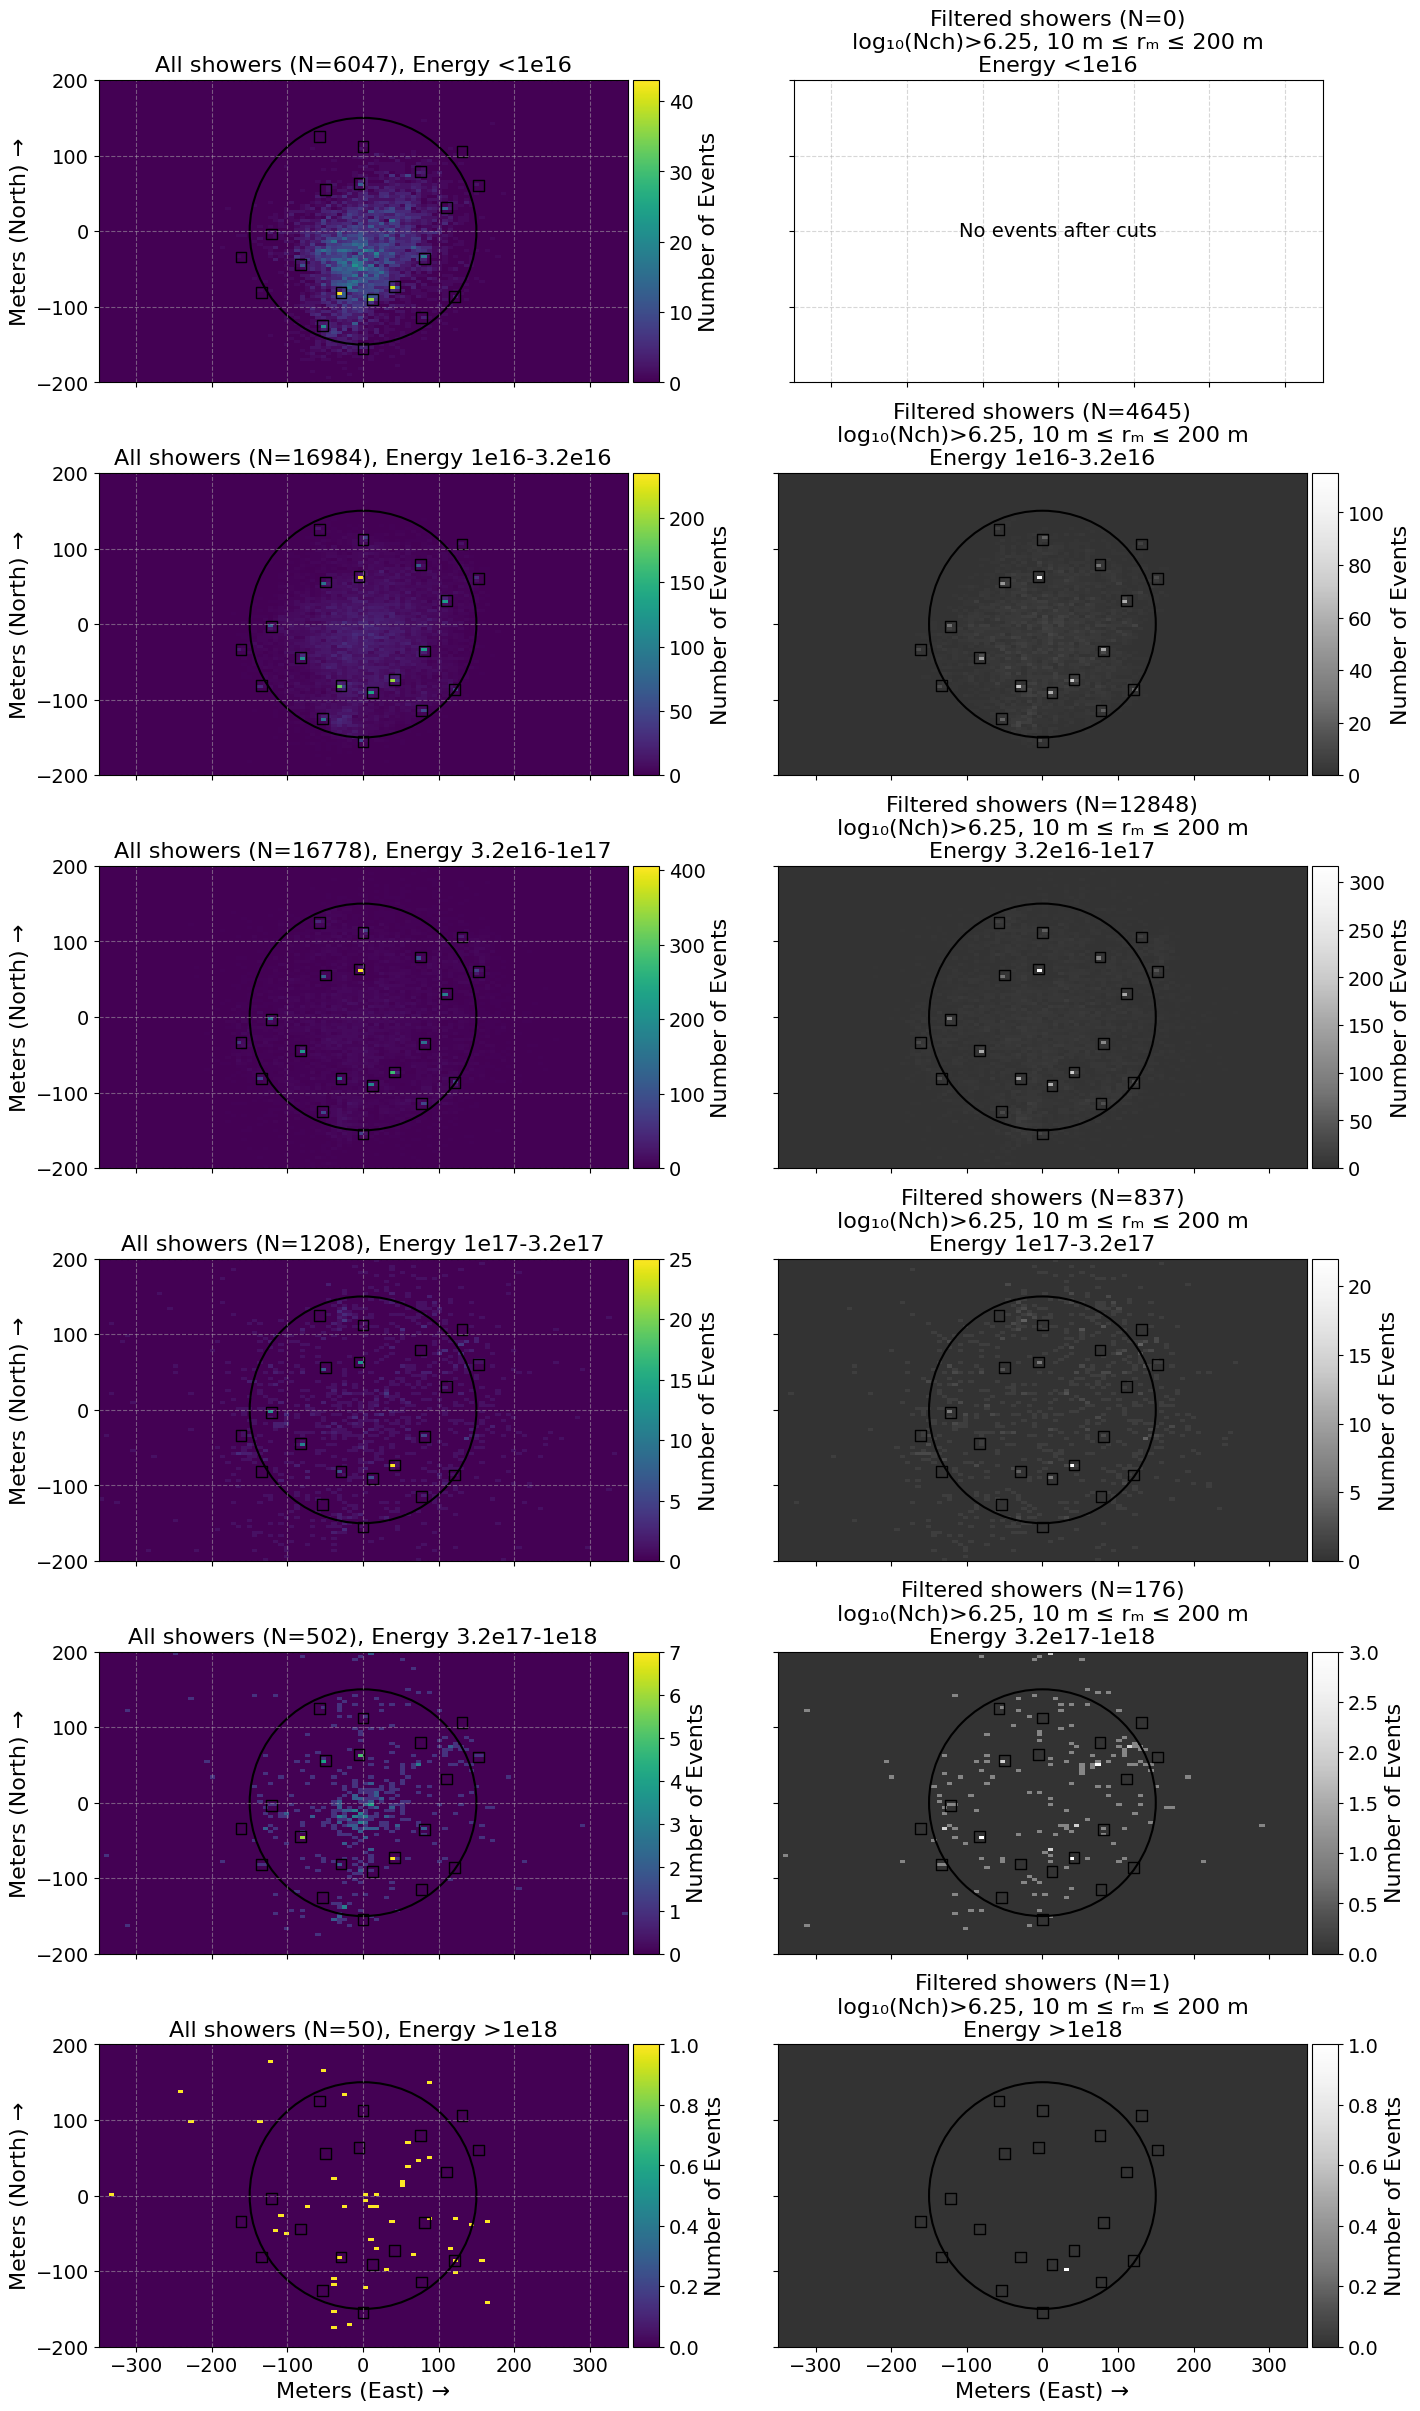

In [1]:
"""
Process and visualize LORA air-shower events by energy range.

This script:
- Extracts event parameters (core position, energy, Nch, rM) from `.dat` files.
- Applies quality cuts: log10(Nch) > 6.25 and 10 m ≤ rM ≤ 200 m.
- Bins events into predefined energy intervals.
- Saves the filtered event list to a text file.
- Produces 2D histograms of shower core positions (all vs. filtered) per energy bin,
  overlaid with detector positions and fiducial circle.
"""

import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# === Global font settings ===
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.titlesize': 18
})

# === Helper to extract event info ===
def extract_event_info(file_path):
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
        if len(lines) < 2 or lines[1].startswith("//"):
            return None
        vals = lines[1].strip().split('\t')
        core_x = float(vals[2])
        core_y = float(vals[3])
        energy = float(vals[6])
        N_ch   = float(vals[14])
        r_M    = float(vals[9])
        if energy <= 0 or N_ch <= 0 or r_M <= 0:
            return None
        log_N_ch = np.log10(N_ch)
        return core_x, core_y, energy, N_ch, r_M, log_N_ch
    except (ValueError, IndexError):
        return None

# === Data dir & months ===
data_dir = '/home/wecapstor3/capn/mppi138h/LOFAR/scratch/stuti/lora-datapipeline/Output_all_root_events'
years         = [str(y) for y in range(2011, 2022)]
target_months = [f"{y}05" for y in years] + [f"{y}11" for y in years]

# === Detector layout ===
detector_coords = np.array([
    [12.84, -90.78], [-29.28, -81.25], [-53.99, -125.12], [-0.10, -154.98],
    [-121.32, -3.68], [-83.25, -44.26], [-161.38, -34.07], [-133.88, -81.31],
    [76.14, 79.31], [152.35, 60.44], [110.83, 31.33], [130.88, 105.86],
    [77.63, -114.43], [120.95, -86.24], [41.87, -72.91], [81.13, -35.61],
    [-57.46, 125.07], [0.10, 112.14], [-5.30, 63.44], [-49.93, 55.55],
    [462.22, 106.33], [478.05, 30.78], [525.42, 44.37], [513.12, 109.06],
    [-188.11, -420.26], [-138.16, -372.49], [-101.12, -418.56], [-152.27, -459.11],
    [-647.88, -254.65], [-710.39, -312.13], [-673.64, -340.07], [-623.74, -298.66],
    [-458.37, 330.89], [-436.60, 253.78], [-485.96, 248.10], [-496.71, 308.90],
    [-192.97, 365.33], [-240.05, 304.57], [-155.08, 317.67], [-201.27, 275.63]
])
det_x, det_y = detector_coords[:, 0], detector_coords[:, 1]

# === Prepare energy‐bin containers ===
energy_bins_all = {
    "<1e16": [], "1e16-3.2e16": [], "3.2e16-1e17": [],
    "1e17-3.2e17": [], "3.2e17-1e18": [], ">1e18": []
}
energy_bins_cut = {
    "<1e16": [], "1e16-3.2e16": [], "3.2e16-1e17": [],
    "1e17-3.2e17": [], "3.2e17-1e18": [], ">1e18": []
}
filtered_events = []

# === Collect & filter ===
for fname in os.listdir(data_dir):
    if not fname.endswith('.dat') or not any(m in fname for m in target_months):
        continue
    info = extract_event_info(os.path.join(data_dir, fname))
    if info is None:
        continue
    x, y, E, Nch, rM, logN = info

    # All events
    if   E < 1e16:               energy_bins_all["<1e16"].append((x, y))
    elif E < 2e16:              energy_bins_all["1e16-3.2e16"].append((x, y))
    elif E < 1e17:              energy_bins_all["3.2e16-1e17"].append((x, y))
    elif E < 2e17:              energy_bins_all["1e17-3.2e17"].append((x, y))
    elif E < 1e18:              energy_bins_all["3.2e17-1e18"].append((x, y))
    else:                       energy_bins_all[">1e18"].append((x, y))

    # Apply cuts
    if logN > 6.25 and 10 <= rM <= 200:
        filtered_events.append((fname, x, y, E, Nch, rM, logN))
        if   E < 1e16:               energy_bins_cut["<1e16"].append((x, y))
        elif E < 2e16:              energy_bins_cut["1e16-3.2e16"].append((x, y))
        elif E < 1e17:              energy_bins_cut["3.2e16-1e17"].append((x, y))
        elif E < 2e17:              energy_bins_cut["1e17-3.2e17"].append((x, y))
        elif E < 1e18:              energy_bins_cut["3.2e17-1e18"].append((x, y))
        else:                       energy_bins_cut[">1e18"].append((x, y))

# === (Optional) Save filtered event list ===
with open("filtered_event_after_Nch_rm_cut.txt", "w") as fout:
    fout.write("Filename\tCore_X\tCore_Y\tEnergy\tNch\trM\tlog10(Nch)\n")
    for ev in filtered_events:
        fout.write(f"{ev[0]}\t{ev[1]:.2f}\t{ev[2]:.2f}\t{ev[3]:.2e}\t{ev[4]:.2f}\t{ev[5]:.2f}\t{ev[6]:.2f}\n")
print(f"Saved {len(filtered_events)} filtered events.")

# === Plotting all vs filtered in 2‐column grid ===
energy_labels = list(energy_bins_all.keys())
n_bins        = len(energy_labels)
bins          = 100
xy_range      = [[-350,350], [-200,200]]

fig, axes = plt.subplots(
    n_bins, 2,
    figsize=(14, 4*n_bins),
    sharex=True, sharey=True,
    constrained_layout=True
)

for i, label in enumerate(energy_labels):
    all_events = energy_bins_all[label]
    cut_events = energy_bins_cut[label]
    ax_all, ax_cut = axes[i,0], axes[i,1]

    # --- All showers ---
    if all_events:
        arr = np.array(all_events)
        h1 = ax_all.hist2d(arr[:,0], arr[:,1], bins=bins, range=xy_range, cmap='viridis')
        cax = make_axes_locatable(ax_all).append_axes("right", size="5%", pad=0.05)
        plt.colorbar(h1[3], cax=cax, label='Number of Events')
    else:
        ax_all.text(0.5, 0.5, 'No events found', ha='center', va='center',
                    transform=ax_all.transAxes, fontsize=14)

    ax_all.scatter(det_x, det_y, facecolors='none', edgecolors='black', s=60, marker='s')
    ax_all.add_patch(plt.Circle((0,0),150, fill=False, linewidth=1.5))
    ax_all.set_title(f"All showers (N={len(all_events)}), Energy {label}", fontsize=16)
    ax_all.set_xlim(xy_range[0]); ax_all.set_ylim(xy_range[1])
    ax_all.set_aspect('equal'); ax_all.grid(True, ls='--', alpha=0.5)
    if i == n_bins - 1:
        ax_all.set_xlabel("Meters (East) →", fontsize=16)
    ax_all.set_ylabel("Meters (North) →", fontsize=16)

    # --- Filtered showers ---
    if cut_events:
        arr = np.array(cut_events)
        h2 = ax_cut.hist2d(arr[:,0], arr[:,1], bins=bins, range=xy_range, cmap='Greys_r', alpha=0.8)
        cax = make_axes_locatable(ax_cut).append_axes("right", size="5%", pad=0.05)
        plt.colorbar(h2[3], cax=cax, label='Number of Events')
        ax_cut.scatter(det_x, det_y, facecolors='none', edgecolors='black', s=60, marker='s')
        ax_cut.add_patch(plt.Circle((0,0),150, fill=False, linewidth=1.5))
    else:
        ax_cut.text(0.5, 0.5, 'No events after cuts', ha='center', va='center',
                    transform=ax_cut.transAxes, fontsize=14)
        ax_cut.grid(True, ls='--', alpha=0.5)

    ax_cut.set_title(f"Filtered showers (N={len(cut_events)})\n"
                     "log₁₀(Nch)>6.25, 10 m ≤ rₘ ≤ 200 m\n"
                     f"Energy {label}", fontsize=16)
    ax_cut.set_xlim(xy_range[0]); ax_cut.set_ylim(xy_range[1])
    ax_cut.set_aspect('equal')
    if i == n_bins - 1:
        ax_cut.set_xlabel("Meters (East) →", fontsize=16)

plt.show()


Processing 2011: 725 files
2011: Events before cuts = 725, after cuts = 382
Processing 2012: 5127 files
2012: Events before cuts = 5127, after cuts = 2236
Processing 2013: 7295 files
2013: Events before cuts = 7295, after cuts = 3197
Processing 2014: 6497 files
2014: Events before cuts = 6497, after cuts = 2754
Processing 2015: 2794 files
2015: Events before cuts = 2794, after cuts = 1294
Processing 2016: 5882 files
2016: Events before cuts = 5882, after cuts = 2765
Processing 2017: 3047 files
2017: Events before cuts = 3047, after cuts = 1268
Processing 2018: 2115 files
2018: Events before cuts = 2115, after cuts = 1067
Processing 2019: 4185 files
2019: Events before cuts = 4185, after cuts = 1742
Processing 2020: 2354 files
2020: Events before cuts = 2354, after cuts = 1092
Processing 2021: 1659 files
2021: Events before cuts = 1659, after cuts = 755


/tmp/ipykernel_2288370/2457983096.py:172: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 0.95])


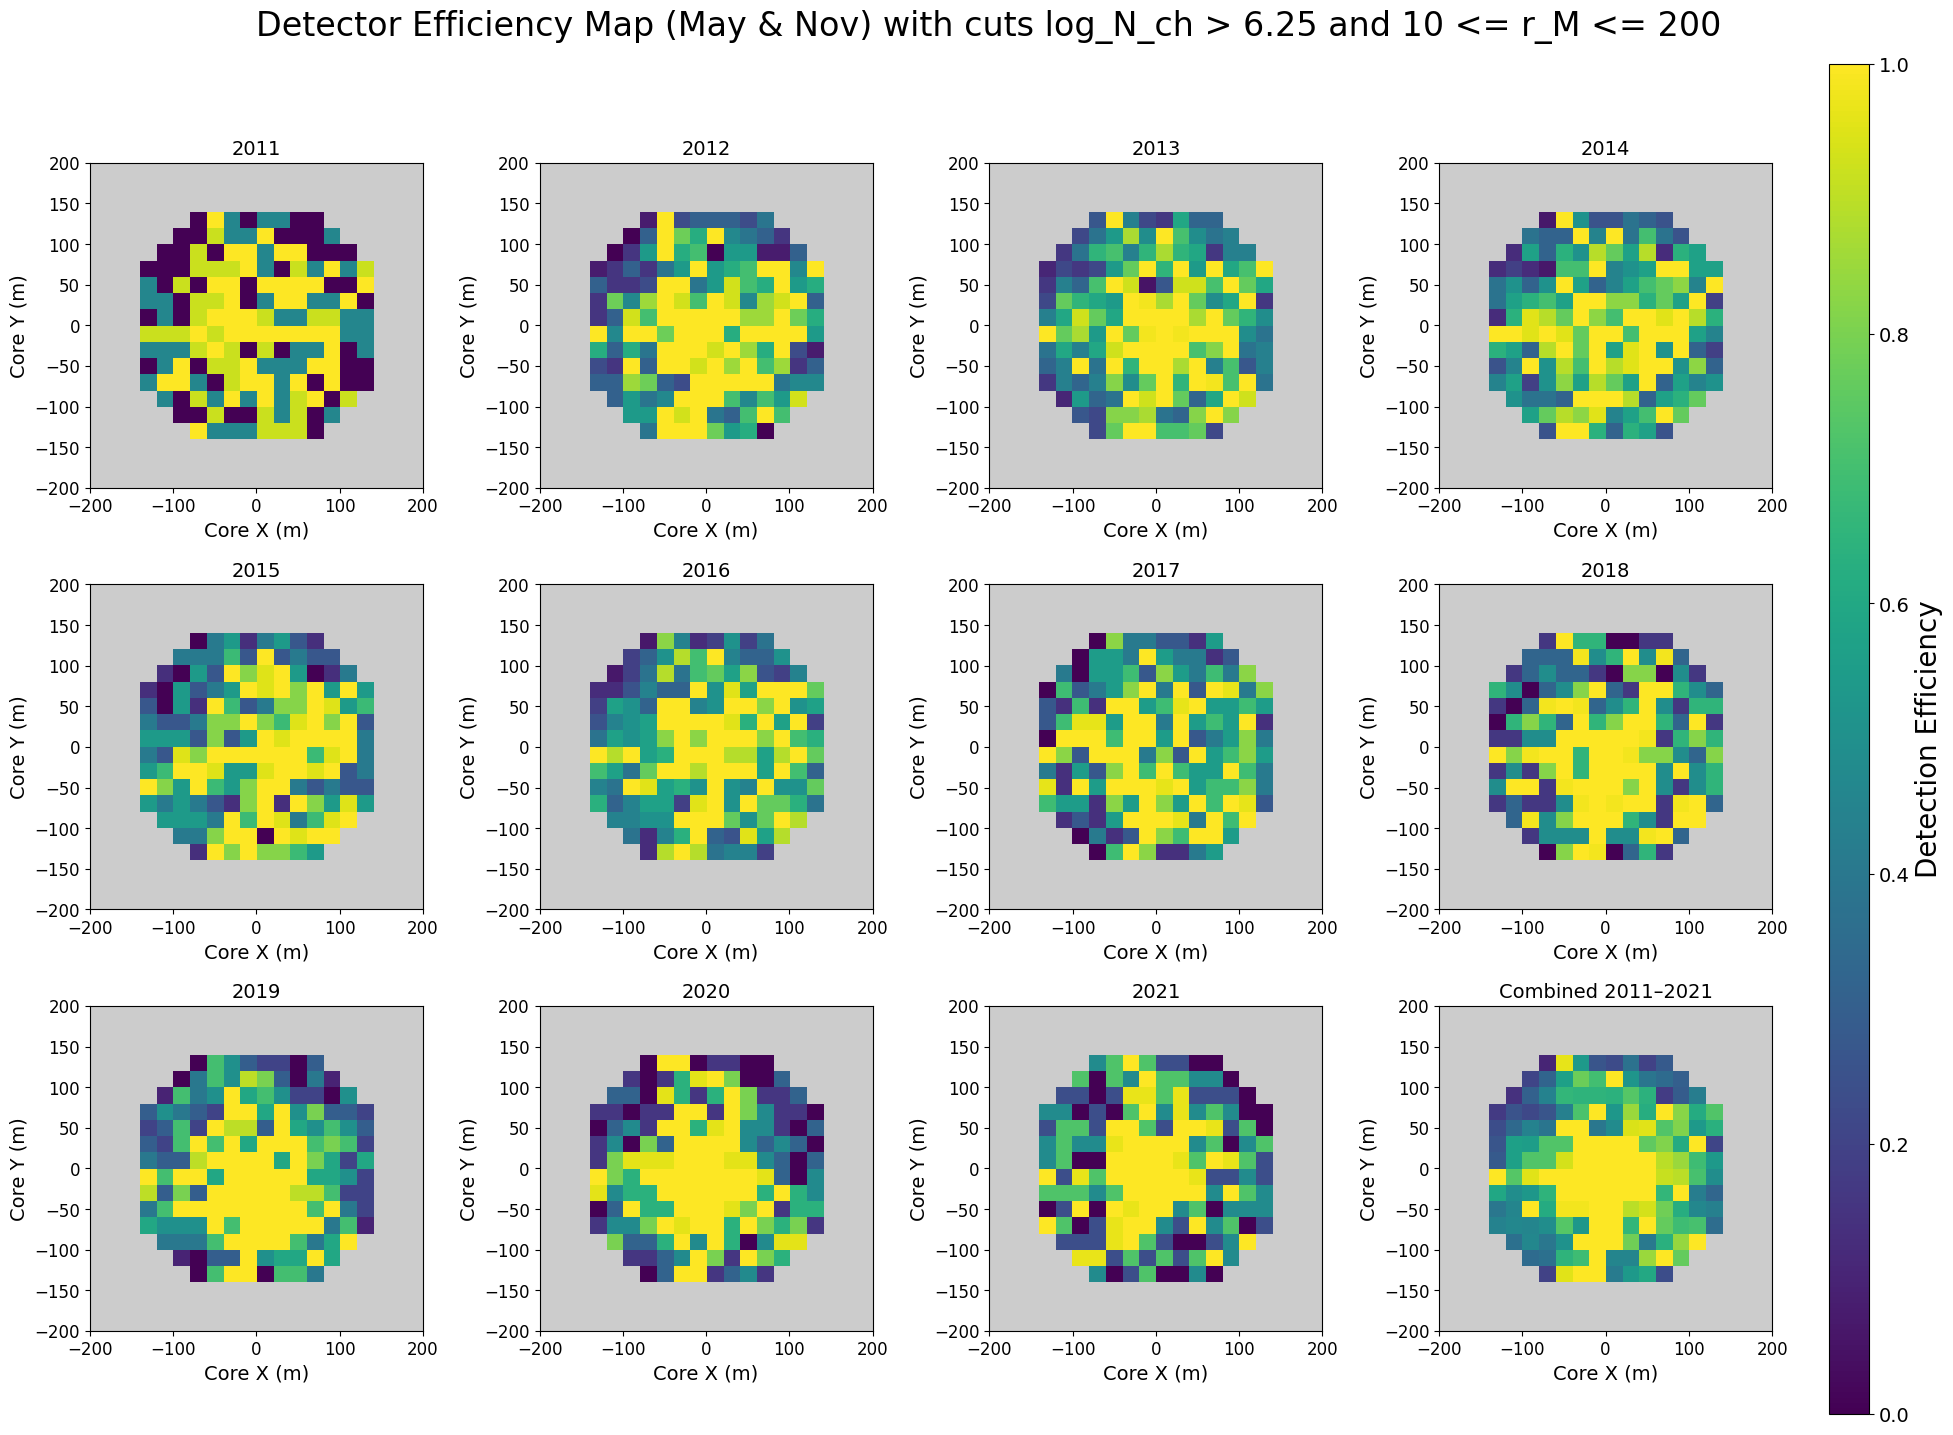

In [2]:
"""
Build and visualize yearly detector efficiency maps for LORA events.

This script:
- Extracts shower core positions, Nch, and rM from `.dat` files (2011–2021).
- Applies quality cuts: log10(Nch) > 6.25 and 10 m ≤ rM ≤ 200 m.
- Constructs 2D efficiency maps by comparing detected shower densities
  to an ideal uniform expectation within a 150 m fiducial radius.
- Produces per-year efficiency maps (May & Nov data) and a combined map (2011–2021).
- Displays results in a multi-panel grid with a shared efficiency colorbar.
"""

import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# === Unified data directory ===
data_dir = '/home/wecapstor3/capn/mppi138h/LOFAR/scratch/stuti/lora-datapipeline/Output_all_root_events'

# === Parameters ===
radius_acceptance = 150  # meters
bin_size = 20
x_edges = np.arange(-200, 200 + bin_size, bin_size)
y_edges = np.arange(-200, 200 + bin_size, bin_size)

# === Function to extract one event ===
def extract_event_info(filepath):
    try:
        with open(filepath, 'r') as f:
            lines = f.readlines()
        if len(lines) < 2 or lines[1].startswith("//"):
            return None
        parts = lines[1].strip().split()

        core_x = float(parts[2])
        core_y = float(parts[3])
        N_ch = float(parts[14])  # check index!
        r_M  = float(parts[9])   # check index!
        energy = float(parts[6]) # not used in cuts but kept for completeness

        return (core_x, core_y, N_ch, r_M, energy)
    except (IndexError, ValueError):
        return None

# === Function to build efficiency map ===
def build_efficiency_map(core_positions):
    detected_counts, _, _ = np.histogram2d(core_positions[:,0], core_positions[:,1], bins=[x_edges, y_edges])
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    Xc, Yc = np.meshgrid(x_centers, y_centers, indexing='ij')
    radii = np.sqrt(Xc**2 + Yc**2)

    expected_counts = np.zeros_like(detected_counts)
    expected_counts[radii < radius_acceptance] = 1
    expected_counts = expected_counts / expected_counts.sum()
    expected_counts *= detected_counts.sum()

    with np.errstate(divide='ignore', invalid='ignore'):
        efficiency_map = detected_counts / expected_counts
        efficiency_map[np.isnan(efficiency_map)] = 0
        efficiency_map[efficiency_map > 1] = 1

    return efficiency_map, radii

# === Setup for plots ===
n_plots = 13
cols = 4
rows = (n_plots + cols - 1) // cols  # ceiling division
fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 4.5 * rows))
axs = axs.flatten()
fig.suptitle("Detector Efficiency Map (May & Nov) with cuts log_N_ch > 6.25 and 10 <= r_M <= 200", fontsize=24)

all_cores_combined = []
plot_idx = 0

for year in range(2011, 2022):
    all_cores_before = []
    Nch_list = []
    rM_list = []

    months = [f"{year}05", f"{year}11"]
    files = []
    for month in months:
        files += glob.glob(os.path.join(data_dir, f"*{month}*.dat"))

    print(f"Processing {year}: {len(files)} files")
    for file in files:
        result = extract_event_info(file)
        if result:
            core_x, core_y, N_ch, r_M, energy = result
            all_cores_before.append([core_x, core_y])
            Nch_list.append(N_ch)
            rM_list.append(r_M)

    if not all_cores_before:
        print(f"Skipping {year}, no data.")
        continue

    # Convert to arrays
    all_cores_before = np.array(all_cores_before)
    Nch_list = np.array(Nch_list)
    rM_list = np.array(rM_list)

    # Apply cuts
    cut_mask = (np.log10(Nch_list) > 6.25) & (rM_list >= 10) & (rM_list <= 200)
    all_cores_after = all_cores_before[cut_mask]

    print(f"{year}: Events before cuts = {len(all_cores_before)}, after cuts = {len(all_cores_after)}")

    if len(all_cores_after) == 0:
        continue

    all_cores_combined.extend(all_cores_after)

    efficiency_map, radii = build_efficiency_map(all_cores_after)

    ax = axs[plot_idx]
    cmap = plt.cm.viridis
    normed = cmap(efficiency_map.T)

    outside_mask = radii.T >= radius_acceptance
    normed[outside_mask] = [0.8, 0.8, 0.8, 1.0]

    ax.imshow(normed,
              extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
              origin='lower',
              aspect='auto',
              vmin=0, vmax=1)
    ax.set_title(f"{year}", fontsize=14)
    ax.set_xlabel("Core X (m)", fontsize=14)
    ax.set_ylabel("Core Y (m)", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)

    plot_idx += 1

# === Combined plot ===
if all_cores_combined:
    all_cores_combined = np.array(all_cores_combined)
    efficiency_map, radii = build_efficiency_map(all_cores_combined)

    ax = axs[plot_idx]
    cmap = plt.cm.viridis
    normed = cmap(efficiency_map.T)
    outside_mask = radii.T >= radius_acceptance
    normed[outside_mask] = [0.8, 0.8, 0.8, 1.0]

    ax.imshow(normed,
              extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
              origin='lower',
              aspect='auto',
              vmin=0, vmax=1)
    ax.set_title("Combined 2011–2021", fontsize=14)
    ax.set_xlabel("Core X (m)", fontsize=14)
    ax.set_ylabel("Core Y (m)", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)

# === Remove unused axes ===
for i in range(plot_idx + 1, len(axs)):
    fig.delaxes(axs[i])

# === Shared colorbar ===
cbar_ax = fig.add_axes([0.92, 0.20, 0.02, 0.75])
norm = Normalize(vmin=0, vmax=1)
sm = ScalarMappable(cmap='viridis', norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Detection Efficiency', fontsize=20)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout(rect=[0, 0, 0.91, 0.95])
plt.show()


Processing 2011-05: 227 files
Processing 2011-11: 498 files
Processing 2012-05: 979 files
Processing 2012-11: 4148 files
Processing 2013-05: 3490 files
Processing 2013-11: 3805 files
Processing 2014-05: 2788 files
Processing 2014-11: 3709 files
Processing 2015-05: 1084 files
Processing 2015-11: 1710 files
Processing 2016-05: 2472 files
Processing 2016-11: 3410 files
Processing 2017-05: 3047 files
Processing 2017-11: 0 files
Processing 2018-05: 1316 files
Processing 2018-11: 799 files
Processing 2019-05: 2404 files
Processing 2019-11: 1781 files
Processing 2020-05: 664 files
Processing 2020-11: 1690 files
Processing 2021-05: 804 files
Processing 2021-11: 855 files


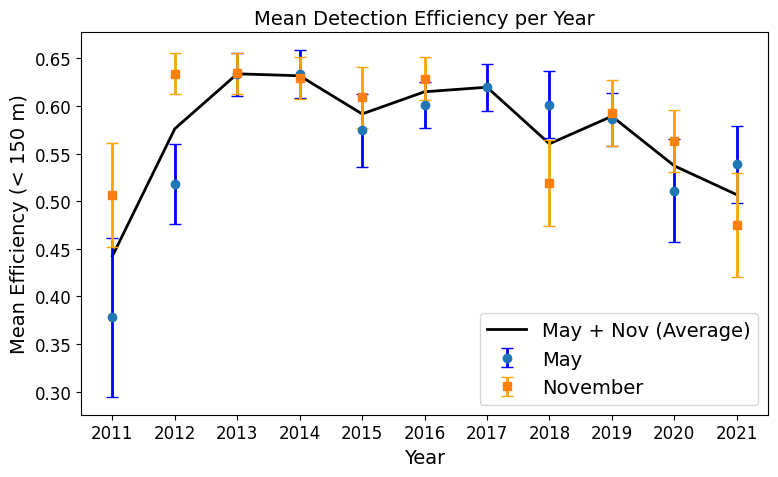

In [ ]:
"""
Compute yearly mean detection efficiency and efficiency map statistics for LORA events.

This script:
- Extracts shower core positions and parameters from `.dat` files (2011–2021).
- Applies quality cuts: log10(Nch) > 6.25 and 10 m ≤ rM ≤ 200 m.
- Separates May and November events, builds 2D efficiency maps inside a 150 m fiducial radius.
- Calculates mean efficiencies with Poisson errors for May, November, and their yearly averages.
- Aggregates efficiency maps across years to compute mean and standard deviation maps.
- Plots annual efficiency trends with error bars for May, November, and the combined average.
"""
import numpy as np
import os
import glob
import matplotlib.pyplot as plt

# === Parameters ===
data_dir = '/home/wecapstor3/capn/mppi138h/LOFAR/scratch/stuti/lora-datapipeline/Output_all_root_events'
radius_acceptance = 150
bin_size = 20
x_edges = np.arange(-800, 600 + bin_size, bin_size)
y_edges = np.arange(-600, 400 + bin_size, bin_size)
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2
Xc, Yc = np.meshgrid(x_centers, y_centers, indexing='ij')
radii = np.sqrt(Xc**2 + Yc**2)
acceptance_mask = radii < radius_acceptance

def extract_event_info(filepath):
    try:
        with open(filepath, 'r') as f:
            lines = f.readlines()
        if len(lines) < 2 or lines[1].startswith("//"):
            return None
        parts = lines[1].strip().split()
        
        core_x = float(parts[2])
        core_y = float(parts[3])
        energy = float(parts[6])
        N_ch   = float(parts[14])
        r_M    = float(parts[9])
        
        if energy <= 0 or N_ch <= 0 or r_M <= 0:
            return None
        
        log_N_ch = np.log10(N_ch)
        
        # Apply cuts
        if log_N_ch > 6.25 and 10 <= r_M <= 200:
            return (core_x, core_y, energy)
        else:
            return None

    except (IndexError, ValueError):
        return None


# === Containers ===
efficiency_maps = []
mean_eff_may, mean_eff_nov = [], []
err_eff_may, err_eff_nov = [], []
years = []

# === Main loop ===
for year in range(2011, 2022):
    may_cores, nov_cores = [], []

    for month, month_cores in zip(['05', '11'], [may_cores, nov_cores]):
        pattern = os.path.join(data_dir, f"*{year}{month}*.dat")
        files = glob.glob(pattern)

        print(f"Processing {year}-{month}: {len(files)} files")
        for file in files:
            result = extract_event_info(file)
            if result:
                x, y, _ = result
                month_cores.append([x, y])

    if not may_cores and not nov_cores:
        print(f"Skipping {year}, no data.")
        continue

    # Process May
    if may_cores:
        cores = np.array(may_cores)
        detected_counts, _, _ = np.histogram2d(cores[:, 0], cores[:, 1],
                                               bins=[x_edges, y_edges])
        expected_counts = np.zeros_like(detected_counts)
        expected_counts[acceptance_mask] = 1
        expected_counts /= expected_counts.sum()
        expected_counts *= detected_counts.sum()

        with np.errstate(divide='ignore', invalid='ignore'):
            efficiency_map = detected_counts / expected_counts
            efficiency_map[np.isnan(efficiency_map)] = 0
            efficiency_map[efficiency_map > 1] = 1

        efficiency_maps.append(efficiency_map)
        mean_eff_may.append(np.mean(efficiency_map[acceptance_mask]))

        N_det_total = detected_counts[acceptance_mask].sum()
        N_exp_total = expected_counts[acceptance_mask].sum()
        err_eff_may.append(np.sqrt(N_det_total) / N_exp_total)

    else:
        mean_eff_may.append(np.nan)
        err_eff_may.append(np.nan)

    # Process November
    if nov_cores:
        cores = np.array(nov_cores)
        detected_counts, _, _ = np.histogram2d(cores[:, 0], cores[:, 1],
                                               bins=[x_edges, y_edges])
        expected_counts = np.zeros_like(detected_counts)
        expected_counts[acceptance_mask] = 1
        expected_counts /= expected_counts.sum()
        expected_counts *= detected_counts.sum()

        with np.errstate(divide='ignore', invalid='ignore'):
            efficiency_map = detected_counts / expected_counts
            efficiency_map[np.isnan(efficiency_map)] = 0
            efficiency_map[efficiency_map > 1] = 1

        efficiency_maps.append(efficiency_map)
        mean_eff_nov.append(np.mean(efficiency_map[acceptance_mask]))

        N_det_total = detected_counts[acceptance_mask].sum()
        N_exp_total = expected_counts[acceptance_mask].sum()
        err_eff_nov.append(np.sqrt(N_det_total) / N_exp_total)

    else:
        mean_eff_nov.append(np.nan)
        err_eff_nov.append(np.nan)

    years.append(year)

# === Combined averages ===
mean_eff_per_year = [
    np.nanmean([may, nov]) for may, nov in zip(mean_eff_may, mean_eff_nov)
]

# === Efficiency map stack statistics ===
eff_stack = np.stack(efficiency_maps, axis=0)
eff_std_map = np.std(eff_stack, axis=0)
eff_mean_map = np.mean(eff_stack, axis=0)

# === Plot with error bars ===
plt.figure(figsize=(8, 5))
plt.plot(years, mean_eff_per_year, label="May + Nov (Average)", color='black', linewidth=2)

plt.errorbar(years, mean_eff_may, yerr=err_eff_may,
             fmt='o', color='tab:blue', ecolor='blue',
             elinewidth=2, capsize=4, label="May")

plt.errorbar(years, mean_eff_nov, yerr=err_eff_nov,
             fmt='s', color='tab:orange', ecolor='orange',
             elinewidth=2, capsize=4, label="November")

plt.xlabel("Year", fontsize=14)
plt.ylabel("Mean Efficiency (< 150 m)", fontsize=14)
plt.title("Mean Detection Efficiency per Year", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xticks(years)
plt.legend()
plt.tight_layout()
plt.show()
